## Ainti-dervatives

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

### Data

In [68]:
## Data
data_train = np.load("data/antiderivative_aligned_train.npz", allow_pickle=True)
x_train_np = data_train["X"][0]     # (n_train, grid_size) = (150, 100)
c_train_np = data_train["X"][1]     # (grid_size, 1)       = (100, 1)
y_train_np = data_train["y"]        # (n_train, grid_size) = (150, 100)

data_test = np.load("data/antiderivative_aligned_test.npz", allow_pickle=True)
x_test_np = data_test["X"][0]       # (n_test, grid_size)  = (1000, 100)
c_test_np = data_test["X"][1]       # (grid_size, 1)       = (100, 1)
y_test_np = data_test["y"]          # (n_test, grid_size)  = (1000, 100)

grid_size = c_train_np.shape[0]
n_train = x_train_np.shape[0]
n_test = x_test_np.shape[0]

c_train_np = np.tile(c_train_np.flatten()[None, :], [n_train, 1]) # (150, 100)
c_test_np = np.tile(c_test_np.flatten()[None, :], [n_test, 1])    # (1000, 100)

In [69]:
## Dataloader
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

x_train = torch.tensor(x_train_np).float()  # (150, 100)
c_train = torch.tensor(c_train_np).float()  # (150, 100)
y_train = torch.tensor(y_train_np).float()  # (150, 100)

x_test = torch.tensor(x_test_np).float()    # (1000, 100)
c_test = torch.tensor(c_test_np).float()    # (1000, 100)
y_test = torch.tensor(y_test_np).float()    # (1000, 100)

train_loader = DataLoader(TensorDataset(x_train, c_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, c_test, y_test), batch_size=batch_size, shuffle=False)

x, c, y = next(iter(train_loader))
print(">> Batch:", x.shape, c.shape, y.shape)

>> Batch: torch.Size([32, 100]) torch.Size([32, 100]) torch.Size([32, 100])


### Model

In [47]:
class MLP(nn.Module):
    def __init__(self, layer_sizes, activation, final_activation=None):
        super().__init__()
        self.input_size = layer_sizes[0]
        self.output_size = layer_sizes[-1]

        layers = []
        for i in range(len(layer_sizes) - 2):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            layers.append(activation)
        layers.append(nn.Linear(layer_sizes[-2], layer_sizes[-1]))

        if final_activation is not None:
            layers.append(final_activation)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class DeepOnet(nn.Module):
    def __init__(self, grid_size, width):
        super().__init__()
        self.branch_net = MLP(layer_sizes=[grid_size, 64, 64, width], 
                              activation=nn.ReLU())
        self.trunk_net = MLP(layer_sizes=[1, 64, 64, width], 
                             activation=nn.Tanh(), final_activation=nn.Tanh())

    def forward(self, x, c):
        out_branch = self.branch_net(x)
        out_trunk = self.trunk_net(c)
        out = torch.sum(out_branch * out_trunk, axis=-1)
        return out

### Training

In [50]:
# Training
def preprocess(x, c, y):
    grid_size = x.shape[1]
    x = x[:, None, :].repeat(1, grid_size, 1)   # (N, grid_size) -> (N, grid_size, grid_size)
    c = c[:, :, None]                           # (N, grid_size) -> (N, grid_size, 1)
    return x.to(device), c.to(device), y.to(device)

n_epochs = 1000
learning_rate = 1e-3

set_seed(42)
model = DeepOnet(grid_size, width=64).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

for epoch in range(1, n_epochs + 1):
    model.train()
    loss_mse = 0
    train_loss = 0
    for x, c, y in train_loader:
        x, c, y = preprocess(x, c, y)
        y_pred = model(x, c)
        loss = loss_fn(y_pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, c, y in test_loader:
            x, c, y = preprocess(x, c, y)
            y_pred = model(x, c)
            test_loss += loss_fn(y_pred, y).item()

    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    scheduler.step()

    if epoch % (n_epochs // 10) == 0:
        print(f"[{epoch:4d}/{n_epochs}] (lr: {scheduler.get_last_lr()[0]:.2e}) "
              f"train_loss: {train_loss:.2e} | test_loss: {test_loss:.2e}")

[ 100/1000] (lr: 9.50e-04) train_loss: 7.58e-04 | test_loss: 6.07e-04
[ 200/1000] (lr: 9.02e-04) train_loss: 2.64e-03 | test_loss: 9.56e-04
[ 300/1000] (lr: 8.57e-04) train_loss: 2.65e-04 | test_loss: 2.94e-04
[ 400/1000] (lr: 8.15e-04) train_loss: 2.70e-04 | test_loss: 2.75e-04
[ 500/1000] (lr: 7.74e-04) train_loss: 2.01e-04 | test_loss: 2.30e-04
[ 600/1000] (lr: 7.35e-04) train_loss: 7.34e-05 | test_loss: 1.15e-04
[ 700/1000] (lr: 6.98e-04) train_loss: 3.16e-04 | test_loss: 2.56e-04
[ 800/1000] (lr: 6.63e-04) train_loss: 9.18e-05 | test_loss: 1.20e-04
[ 900/1000] (lr: 6.30e-04) train_loss: 7.91e-05 | test_loss: 8.37e-05
[1000/1000] (lr: 5.99e-04) train_loss: 1.61e-04 | test_loss: 1.78e-04


### Evaluation

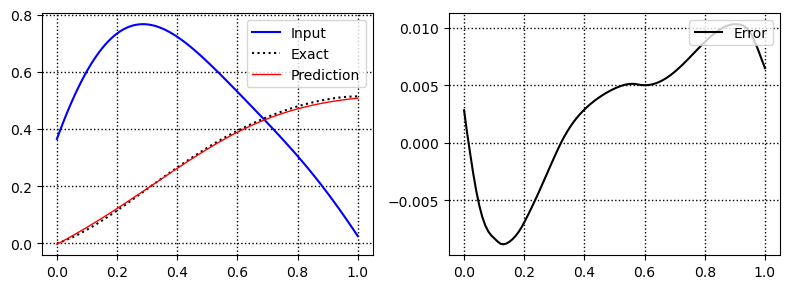

In [70]:
## Evaluation
model.eval()
with torch.no_grad():
    x, c, y = preprocess(x_test, c_test, y_test)
    y_pred = model(x, c)

y_pred_np = y_pred.cpu().detach().numpy()

idx = 10
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 3))
ax1.plot(c_test_np[idx], x_test_np[idx], 'b', label="Input")
ax1.plot(c_test_np[idx], y_test_np[idx], 'k:', label="Exact")
ax1.plot(c_test_np[idx], y_pred_np[idx], 'r', lw=1, label="Prediction")
ax2.plot(c_test_np[idx], y_test_np[idx] - y_pred_np[idx], 'k', label="Error")

for ax in (ax1, ax2):
    ax.legend(loc="upper right")
    ax.grid(color='k', ls=':', lw=1)
fig.tight_layout()
plt.show()